TURKISH BANK ATM TRANSACTIONS 

Introduction.


Don't you just hate it when you get to the ATM after a long travel and you can't withdraw because the ATM machine is out of cash. 

Yeah me too. Now you can't get that delightful looking sheperd's pie from the bakery that only accepts cash. Absolutely hate it. 

With predictive analytics we have a way of stopping that from happening using time series forecasting. As long as we have values and a datetime series we can predict future values.

In this project I will utilize baseline models, Auto Regressive Integrated Moving Average (ARIMA), Seasonal Auto Regressive Integrated Moving Average (SARIMA) and the Prophet model from facebook.

Data Extraction

The goal of this project is to forecast future amounts for needed ATM Balances that would satisfy the transaction demand based on hourly recorded data for a week in different places in the city of Izmir, Turkey. The dataset was extracted from Kaggle as a comma separated values file format and contains 60312 rows and 13 columns. It was loaded into a database in the MySQL Workbench. The main columns for this project are the transaction time and the atm balance. The data types for these column are datetime (%Y-%m-%d %H-%M-%S) and integer respectively.

Library Importation

The MySQL credentials were stored in an .env file 

In [1]:
import os
from dotenv import load_dotenv
import mysql.connector
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive
#import matplotlib.dates as mdates
from statsforecast.models import AutoARIMA
from functools import partial
from utilsforecast.feature_engineering import fourier, time_features, pipeline
from prophet import Prophet
import itertools 
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import register_performance_metric, rolling_mean_by_h
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly, plot_components_plotly


In [2]:
load_dotenv()

True

In [3]:
try:
    conn = mysql.connector.connect(
        host = os.getenv("DB_HOST"),
        user = os.getenv("DB_USER"),
        password = os.getenv("DB_PASSWORD"),
        database = os.getenv("DB_NAME")
    )
    
    if conn.is_connected():
        print("Connected to the database")
    else:
        print("Failed to connect to database")
        
except mysql.connector.Error as err:
    print(f"Error: {err}")
    


Connected to the database


In [4]:
df = pd.read_sql("SELECT * FROM atm_transactions", conn)
df.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_8072\2134903970.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM atm_transactions", conn)


atmId                  atmName atmCity  \
0  atm350000          ALIAGA BAGLI SB   Izmir   
1  atm350001  ALIAGA ISTIKLAL CADDESI   Izmir   
2  atm350002         ALIAGA PAZARYERI   Izmir   
3  atm350003       ALIAGA SAHIL PARKI   Izmir   
4  atm350004            ALIAGA SUBE-1   Izmir   

                         atmAddress  totalBalance  numberIncomeTransition  \
0           Aliaga Petkim Tesisleri         40000                       0   
1        ATATURK ISTIKLAL CD. NO:97         40000                       0   
2        ALIAGA KAPALI PAZAR GIRISI         40000                       0   
3  ALIAGA HIKMET CD.SAHIL PARKI ONU         40000                       0   
4       Istiklal Caddesi No: 64 / A         40000                       0   

   numberOutcomeTransition  totalIncome  totalOutcome  totalNumberTransaction  \
0                        0            0             0                       0   
1                        0            0             0                       0   
2                        0            0             0                       0   
3                        0            0             0                       0   
4                        0            0             0                       0   

         day transactionTime  
0  Wednesday      2020-01-01  
1  Wednesday      2020-01-01  
2  Wednesday      2020-01-01  
3  Wednesday      2020-01-01  
4  Wednesday      2020-01-01

In [5]:
df.shape

(60312, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60312 entries, 0 to 60311
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   atmId                    60312 non-null  object        
 1   atmName                  60312 non-null  object        
 2   atmCity                  60312 non-null  object        
 3   atmAddress               60312 non-null  object        
 4   totalBalance             60312 non-null  int64         
 5   numberIncomeTransition   60312 non-null  int64         
 6   numberOutcomeTransition  60312 non-null  int64         
 7   totalIncome              60312 non-null  int64         
 8   totalOutcome             60312 non-null  int64         
 9   totalNumberTransaction   60312 non-null  int64         
 10  day                      60312 non-null  object        
 11  transactionTime          60312 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(6), 

In [7]:
df.describe()

totalBalance  numberIncomeTransition  numberOutcomeTransition  \
count  60312.000000            60312.000000             60312.000000   
mean   24903.350245               48.157348                55.087711   
min        0.000000                0.000000                 0.000000   
25%    15050.000000               16.000000                16.000000   
50%    25820.000000               50.000000                64.000000   
75%    35335.000000               76.000000                84.000000   
max    57050.000000              100.000000               100.000000   
std    12140.601470               31.311663                33.359996   

        totalIncome  totalOutcome  totalNumberTransaction  \
count  60312.000000  60312.000000            60312.000000   
mean    3089.089733   3533.655989              103.245059   
min        0.000000      0.000000                0.000000   
25%     1015.000000   1015.000000               27.000000   
50%     3145.000000   4075.000000              125.000000   
75%     4835.000000   5310.000000              153.000000   
max     8440.000000   9710.000000              200.000000   
std     2063.629130   2200.777610               61.044607   

                     transactionTime  
count                          60312  
mean   2020-01-04 11:47:37.938718464  
min              2020-01-01 00:00:00  
25%              2020-01-02 17:45:00  
50%              2020-01-04 11:30:00  
75%              2020-01-06 05:15:00  
max              2020-01-07 23:00:00  
std                              NaN

In [8]:
df['transactionTime'] = pd.to_datetime(df['transactionTime']).dt.strftime('%y-%m-%d %h:%I:%s')

In [9]:
df.head()

atmId                  atmName atmCity  \
0  atm350000          ALIAGA BAGLI SB   Izmir   
1  atm350001  ALIAGA ISTIKLAL CADDESI   Izmir   
2  atm350002         ALIAGA PAZARYERI   Izmir   
3  atm350003       ALIAGA SAHIL PARKI   Izmir   
4  atm350004            ALIAGA SUBE-1   Izmir   

                         atmAddress  totalBalance  numberIncomeTransition  \
0           Aliaga Petkim Tesisleri         40000                       0   
1        ATATURK ISTIKLAL CD. NO:97         40000                       0   
2        ALIAGA KAPALI PAZAR GIRISI         40000                       0   
3  ALIAGA HIKMET CD.SAHIL PARKI ONU         40000                       0   
4       Istiklal Caddesi No: 64 / A         40000                       0   

   numberOutcomeTransition  totalIncome  totalOutcome  totalNumberTransaction  \
0                        0            0             0                       0   
1                        0            0             0                       0   
2                        0            0             0                       0   
3                        0            0             0                       0   
4                        0            0             0                       0   

         day      transactionTime  
0  Wednesday  2020-01-01 00:00:00  
1  Wednesday  2020-01-01 00:00:00  
2  Wednesday  2020-01-01 00:00:00  
3  Wednesday  2020-01-01 00:00:00  
4  Wednesday  2020-01-01 00:00:00

In [10]:
df.tail()

atmId              atmName atmCity  \
60307  atm35000354       TORBALI SUBE-2   Izmir   
60308  atm35000355          URLA ISKELE   Izmir   
60309  atm35000356  URLA MEYDAN AVM ONU   Izmir   
60310  atm35000357          URLA SUBE-1   Izmir   
60311  atm35000358          URLA SUBE-2   Izmir   

                                              atmAddress  totalBalance  \
60307        Tepekoy Mahallesi Agalar Caddesi No: 10 / A         16665   
60308                                        URLA ISKELE          7925   
60309  HACI ISA MAHALLESI BARATALI BULVARI NO:40/71 A...         25920   
60310     Hac Isa Mahallesi Bulent Baratal Bulvar No: 74         30295   
60311     Hac Isa Mahallesi Bulent Baratal Bulvar No: 74         11040   

       numberIncomeTransition  numberOutcomeTransition  totalIncome  \
60307                      58                       73         4485   
60308                      41                       99         2705   
60309                      92                       94         6135   
60310                      68                       91         4765   
60311                      80                       78         4675   

       totalOutcome  totalNumberTransaction      day      transactionTime  
60307          4330                     131  Tuesday  2020-01-07 23:00:00  
60308          5810                     140  Tuesday  2020-01-07 23:00:00  
60309          6140                     186  Tuesday  2020-01-07 23:00:00  
60310          6535                     159  Tuesday  2020-01-07 23:00:00  
60311          5475                     158  Tuesday  2020-01-07 23:00:00

In [11]:
df['atmCity'].value_counts()

atmCity
Izmir    60312
Name: count, dtype: int64

In [12]:
df['atmName'].value_counts()

atmName
ALIAGA BAGLI SB              168
KARABAGLAR ZEREK PETROL-1    168
GUN SAZAK BULVARI            168
GIRNE CADDESI SB-3           168
GIRNE CADDESI SB-2           168
                            ... 
PARK BORNOVA AVM             168
OZKANLAR SUBE CIVARI         168
OZKANLAR METRO ISTASYONU     168
OTOGAR                       168
URLA SUBE-2                  168
Name: count, Length: 359, dtype: int64

In [13]:
df.loc[df['atmName']=='ALIAGA BAGLI SB']

atmId          atmName atmCity               atmAddress  \
0      atm350000  ALIAGA BAGLI SB   Izmir  Aliaga Petkim Tesisleri   
359    atm350000  ALIAGA BAGLI SB   Izmir  Aliaga Petkim Tesisleri   
718    atm350000  ALIAGA BAGLI SB   Izmir  Aliaga Petkim Tesisleri   
1077   atm350000  ALIAGA BAGLI SB   Izmir  Aliaga Petkim Tesisleri   
1436   atm350000  ALIAGA BAGLI SB   Izmir  Aliaga Petkim Tesisleri   
...          ...              ...     ...                      ...   
58517  atm350000  ALIAGA BAGLI SB   Izmir  Aliaga Petkim Tesisleri   
58876  atm350000  ALIAGA BAGLI SB   Izmir  Aliaga Petkim Tesisleri   
59235  atm350000  ALIAGA BAGLI SB   Izmir  Aliaga Petkim Tesisleri   
59594  atm350000  ALIAGA BAGLI SB   Izmir  Aliaga Petkim Tesisleri   
59953  atm350000  ALIAGA BAGLI SB   Izmir  Aliaga Petkim Tesisleri   

       totalBalance  numberIncomeTransition  numberOutcomeTransition  \
0             40000                       0                        0   
359           39850                       9                       18   
718           39985                       8                       10   
1077          38545                       5                        9   
1436          39260                      79                       70   
...             ...                     ...                      ...   
58517         48420                      83                       80   
58876         43430                      89                       74   
59235         42480                      78                       75   
59594         34500                      53                      100   
59953         38050                      92                       54   

       totalIncome  totalOutcome  totalNumberTransaction        day  \
0                0             0                       0  Wednesday   
359            485          1120                      27  Wednesday   
718            420           875                      18  Wednesday   
1077           140           490                      14  Wednesday   
1436          5220          4185                     149  Wednesday   
...            ...           ...                     ...        ...   
58517         5085          5010                     163    Tuesday   
58876         5250          5250                     163    Tuesday   
59235         4110          5190                     153    Tuesday   
59594         3395          6425                     153    Tuesday   
59953         6100          3055                     146    Tuesday   

           transactionTime  
0      2020-01-01 00:00:00  
359    2020-01-01 02:00:00  
718    2020-01-01 04:00:00  
1077   2020-01-01 06:00:00  
1436   2020-01-01 08:00:00  
...                    ...  
58517  2020-01-07 14:00:00  
58876  2020-01-07 16:00:00  
59235  2020-01-07 18:00:00  
59594  2020-01-07 20:00:00  
59953  2020-01-07 22:00:00  

[168 rows x 12 columns]

In [14]:
df = df.rename(columns={
    'transactionTime': 'ds',
    'totalBalance': 'y',
    'atmName': 'unique_id'
})

In [15]:
small_df = df[['ds', 'y', 'unique_id']].copy()

In [16]:
small_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60312 entries, 0 to 60311
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ds         60312 non-null  object
 1   y          60312 non-null  int64 
 2   unique_id  60312 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [17]:
small_df['ds'] = pd.to_datetime(small_df['ds'])

In [18]:
small_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60312 entries, 0 to 60311
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         60312 non-null  datetime64[ns]
 1   y          60312 non-null  int64         
 2   unique_id  60312 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.4+ MB


In [19]:
horizon = 24

models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=24),
    SeasonalNaive(season_length=24)
]

sf = StatsForecast(models=models, freq="h")
sf.fit(df=small_df)
preds = sf.predict(h=horizon)

In [20]:
preds.head()

unique_id                  ds   Naive  HistoricAverage  \
0  1.SANAYI SITESI SB 2020-01-07 23:00:00  7720.0         24676.25   
1  1.SANAYI SITESI SB 2020-01-08 00:00:00  7720.0         24676.25   
2  1.SANAYI SITESI SB 2020-01-08 01:00:00  7720.0         24676.25   
3  1.SANAYI SITESI SB 2020-01-08 02:00:00  7720.0         24676.25   
4  1.SANAYI SITESI SB 2020-01-08 03:00:00  7720.0         24676.25   

   WindowAverage  SeasonalNaive  
0   20260.833984        24315.0  
1   20260.833984        24315.0  
2   20260.833984        23645.0  
3   20260.833984        23645.0  
4   20260.833984        22780.0

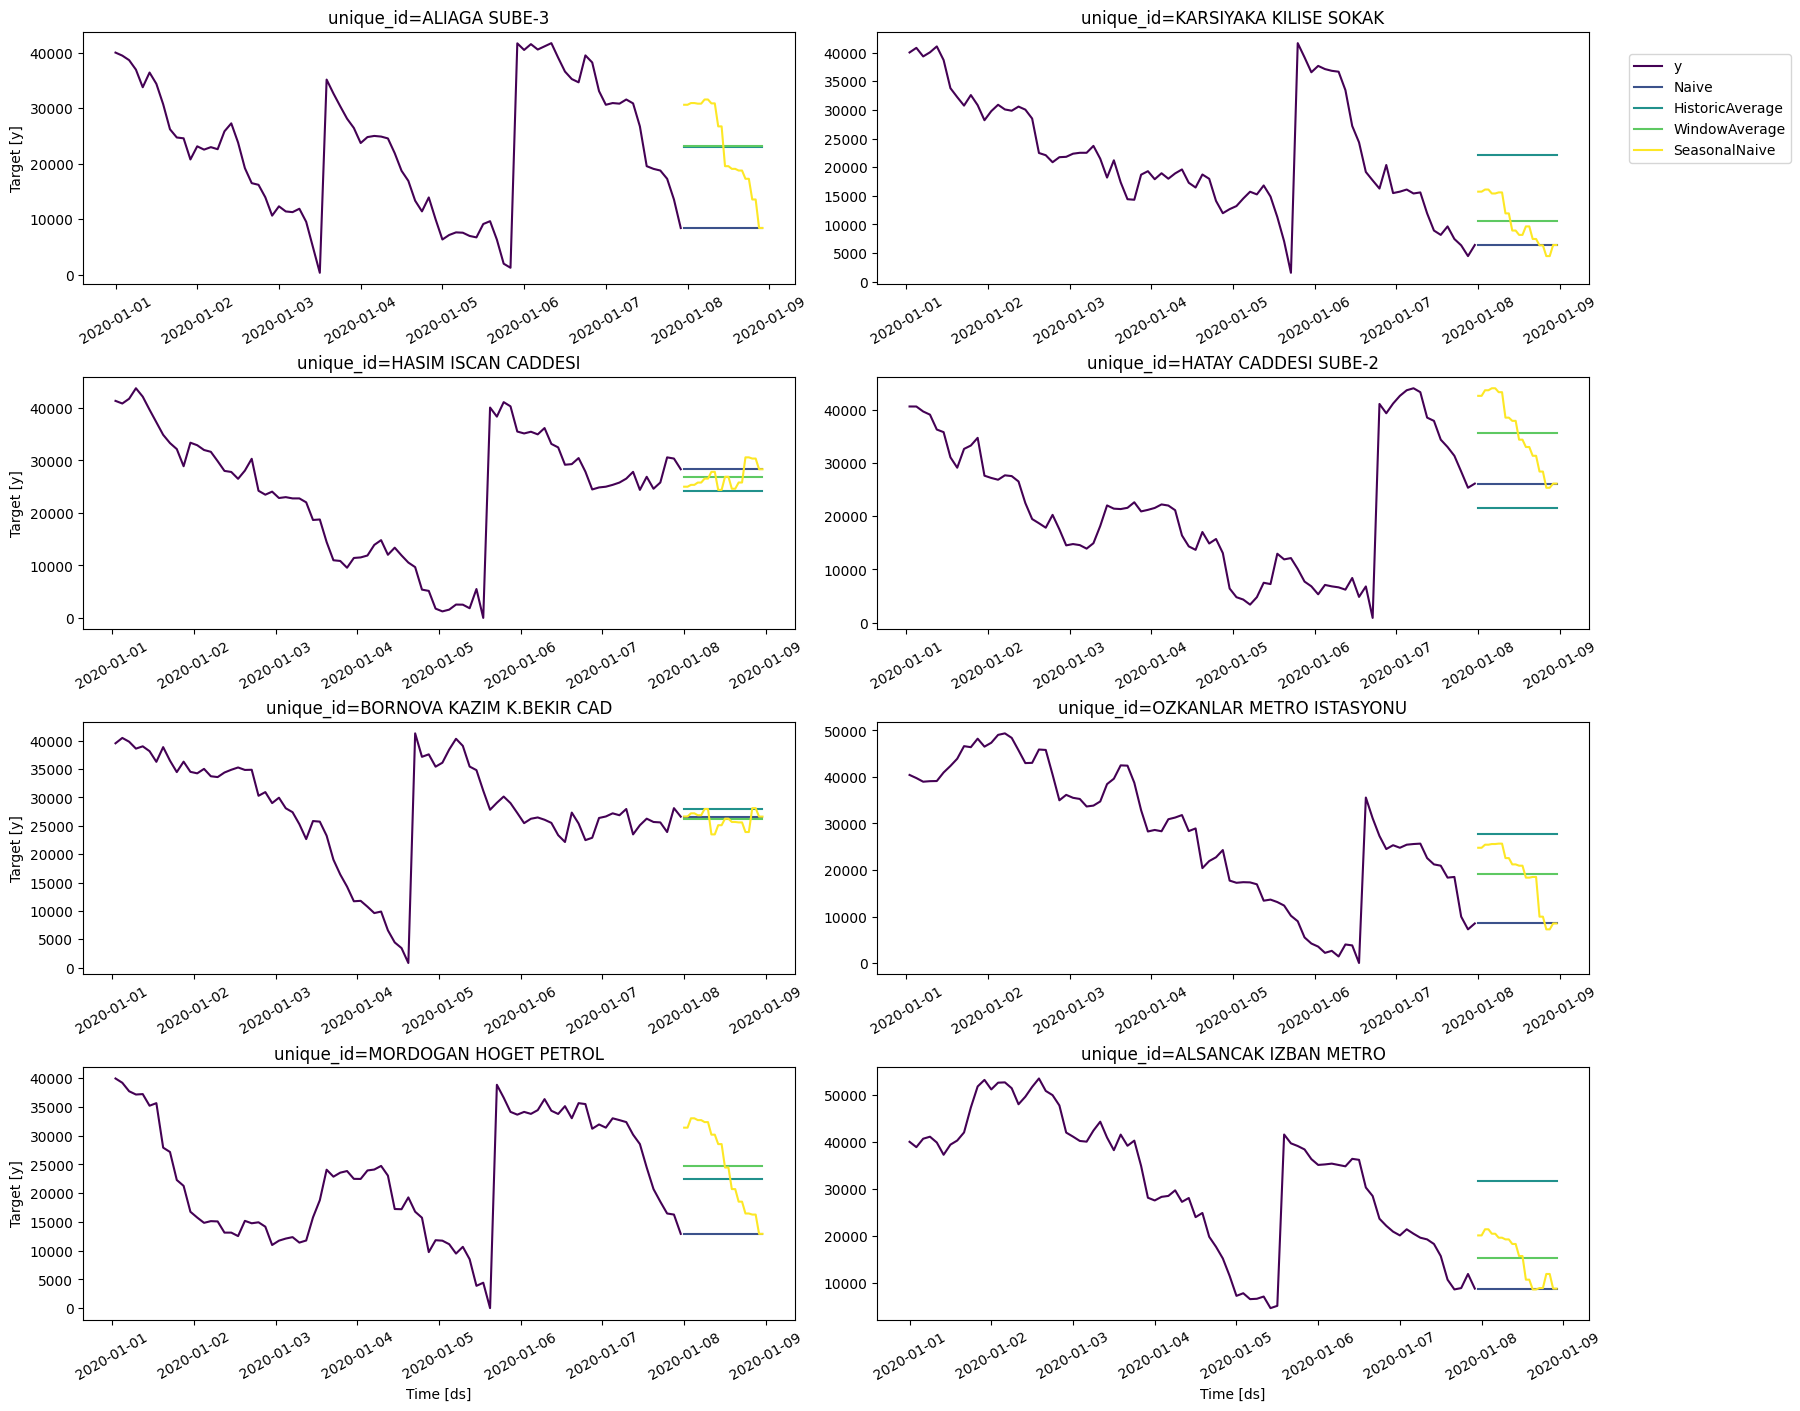

In [21]:
plot_series(
    df=small_df,
    forecasts_df=preds,
    max_insample_length=168,
    palette='viridis'
)


In [22]:
# print(type(fig))
# ALIAGA BAGLI SB

C:\Users\HP\AppData\Local\Temp\ipykernel_8072\2344081213.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


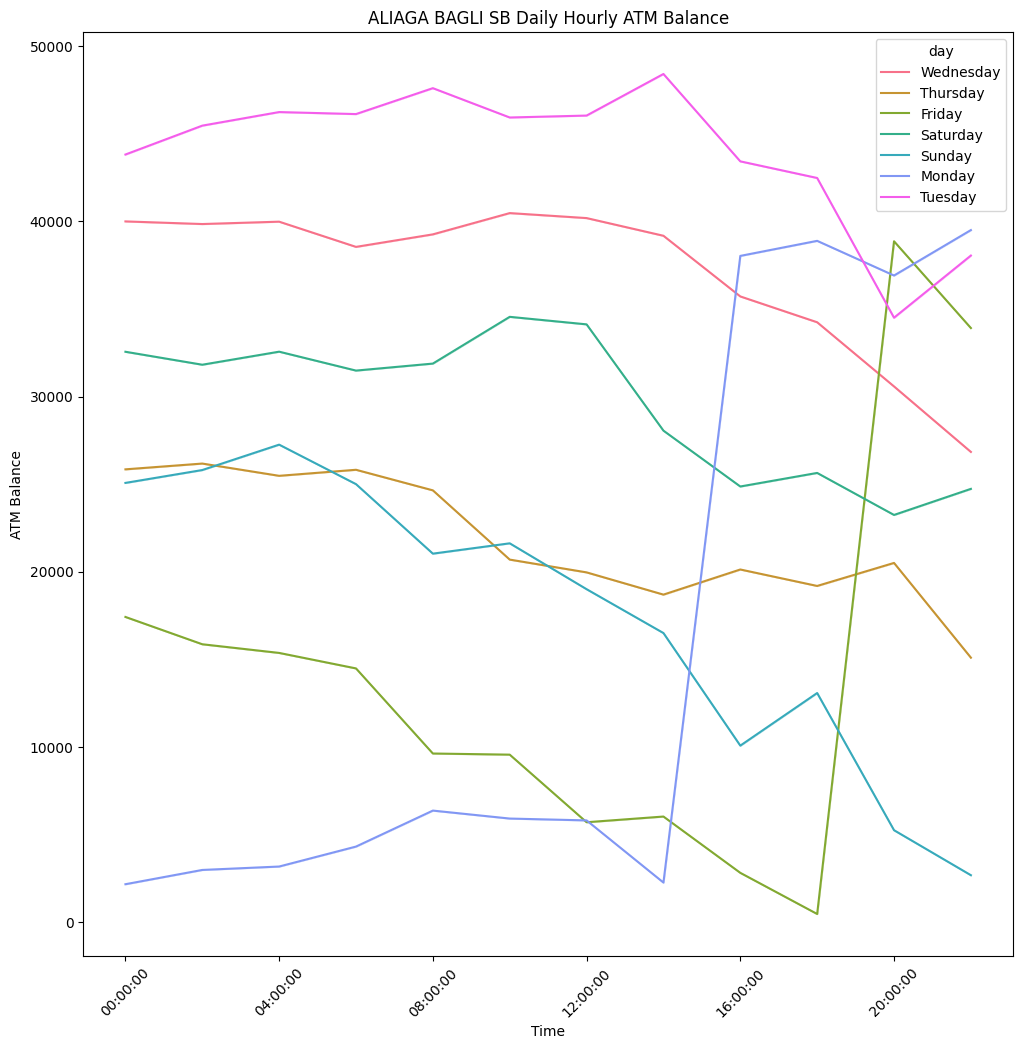

In [23]:
small_df_ABS = small_df[small_df['unique_id']=='ALIAGA BAGLI SB'].copy()
small_df_ABS['hour-minute'] = small_df_ABS['ds'].dt.strftime('%H:%M:%S')
small_df_ABS['day'] = small_df_ABS['ds'].dt.day_name()

plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
sns.lineplot(
    data = small_df_ABS,
    x='hour-minute',
    y='y',
    hue='day',
    palette='husl',
    legend=True,
    ax=ax
)
unique_ticks = small_df_ABS['hour-minute'].unique()
ticks_to_plot = unique_ticks[::2]
ax.set_xticks(ticks=range(0, len(unique_ticks), 2), labels=ticks_to_plot, rotation=45)
ax.set_title('ALIAGA BAGLI SB Daily Hourly ATM Balance')
ax.set_xlabel('Time')
ax.set_ylabel('ATM Balance')
fig.show()


In [24]:
#unique_ids = ['ALIAGA BAGLI SB', 'ALIAGA SAHIL PARKI']
#smaller_df = small_df[small_df['unique_id'].isin(unique_ids)]
test = small_df.groupby('unique_id').tail(7)
train = small_df.drop(test.index).reset_index(drop=True)

In [25]:
train.head()

ds      y                unique_id
0 2020-01-01  40000          ALIAGA BAGLI SB
1 2020-01-01  40000  ALIAGA ISTIKLAL CADDESI
2 2020-01-01  40000         ALIAGA PAZARYERI
3 2020-01-01  40000       ALIAGA SAHIL PARKI
4 2020-01-01  40000            ALIAGA SUBE-1

In [26]:
test.head()

ds      y                unique_id
57799 2020-01-07 10:00:00  45935          ALIAGA BAGLI SB
57800 2020-01-07 10:00:00  33955  ALIAGA ISTIKLAL CADDESI
57801 2020-01-07 10:00:00  26625         ALIAGA PAZARYERI
57802 2020-01-07 10:00:00  30815       ALIAGA SAHIL PARKI
57803 2020-01-07 10:00:00  20005            ALIAGA SUBE-1

In [27]:
sf.fit(df=train)
preds = sf.predict(h=horizon)
eval_df = pd.merge(test, preds, 'left', ['ds', 'unique_id'])

In [28]:
preds.head()

unique_id                  ds   Naive  HistoricAverage  \
0  1.SANAYI SITESI SB 2020-01-07 23:00:00  7720.0     24984.162109   
1  1.SANAYI SITESI SB 2020-01-08 00:00:00  7720.0     24984.162109   
2  1.SANAYI SITESI SB 2020-01-08 01:00:00  7720.0     24984.162109   
3  1.SANAYI SITESI SB 2020-01-08 02:00:00  7720.0     24984.162109   
4  1.SANAYI SITESI SB 2020-01-08 03:00:00  7720.0     24984.162109   

   WindowAverage  SeasonalNaive  
0   24134.791016        35175.0  
1   24134.791016        32955.0  
2   24134.791016        32955.0  
3   24134.791016        29020.0  
4   24134.791016        29020.0

In [29]:
test.head()

ds      y                unique_id
57799 2020-01-07 10:00:00  45935          ALIAGA BAGLI SB
57800 2020-01-07 10:00:00  33955  ALIAGA ISTIKLAL CADDESI
57801 2020-01-07 10:00:00  26625         ALIAGA PAZARYERI
57802 2020-01-07 10:00:00  30815       ALIAGA SAHIL PARKI
57803 2020-01-07 10:00:00  20005            ALIAGA SUBE-1

In [30]:
eval_df.head()

ds      y                unique_id  Naive  HistoricAverage  \
0 2020-01-07 10:00:00  45935          ALIAGA BAGLI SB    NaN              NaN   
1 2020-01-07 10:00:00  33955  ALIAGA ISTIKLAL CADDESI    NaN              NaN   
2 2020-01-07 10:00:00  26625         ALIAGA PAZARYERI    NaN              NaN   
3 2020-01-07 10:00:00  30815       ALIAGA SAHIL PARKI    NaN              NaN   
4 2020-01-07 10:00:00  20005            ALIAGA SUBE-1    NaN              NaN   

   WindowAverage  SeasonalNaive  
0            NaN            NaN  
1            NaN            NaN  
2            NaN            NaN  
3            NaN            NaN  
4            NaN            NaN

In [31]:
evaluation = evaluate(
    eval_df,
    metrics=[mae],
)


evaluation = evaluation.drop(['unique_id'], axis = 1).groupby('metric').mean().reset_index()
evaluation

metric  Naive  HistoricAverage  WindowAverage  SeasonalNaive
0    mae    NaN              NaN            NaN            NaN

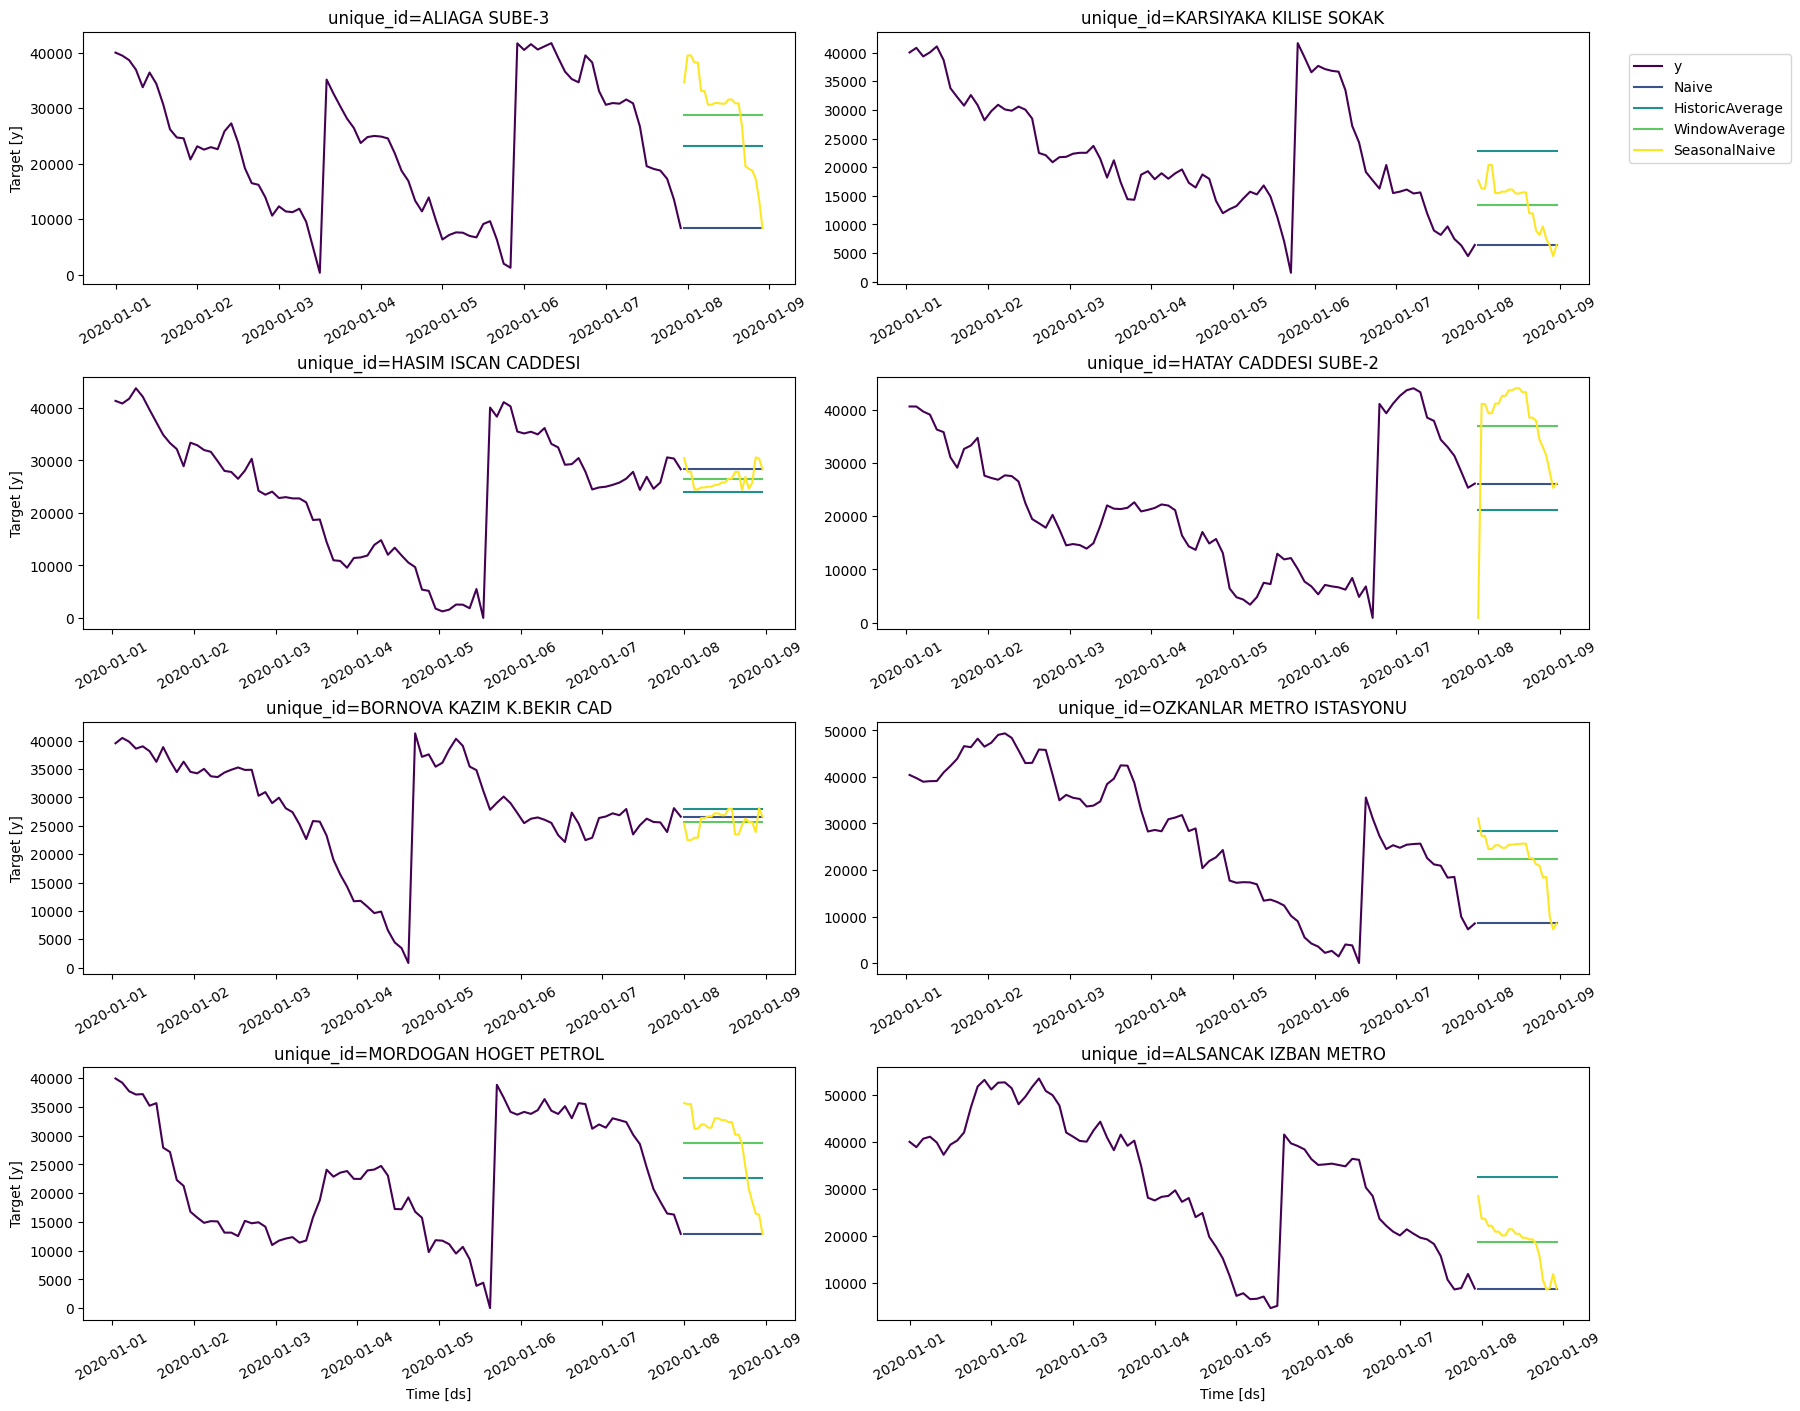

In [32]:
plot_series(
    df=train,
    forecasts_df=preds,
    max_insample_length=168,
    palette='viridis'
)

In [33]:
models = [
    Naive(),
    SeasonalNaive(season_length=24),
    AutoARIMA(seasonal=False, alias='ARIMA'),
    AutoARIMA(season_length=24, alias='SARIMA')
]

sf = StatsForecast(models = models, freq = 'h')

horizon = 24

cv_df = sf.cross_validation(
    h = horizon,
    df=small_df,
    n_windows=2,
    step_size=horizon,
    refit=True
)

cv_df.head()

unique_id                  ds              cutoff       y   Naive  \
0  1.SANAYI SITESI SB 2020-01-06 00:00:00 2020-01-05 22:00:00  2200.0  2450.0   
1  1.SANAYI SITESI SB 2020-01-06 00:00:00 2020-01-05 22:00:00  2200.0  2450.0   
2  1.SANAYI SITESI SB 2020-01-06 02:00:00 2020-01-05 22:00:00  1790.0  2450.0   
3  1.SANAYI SITESI SB 2020-01-06 02:00:00 2020-01-05 22:00:00  1790.0  2450.0   
4  1.SANAYI SITESI SB 2020-01-06 04:00:00 2020-01-05 22:00:00  1965.0  2450.0   

   SeasonalNaive        ARIMA       SARIMA  
0         7965.0  2134.453857  2134.453857  
1         7965.0  1818.907593  1818.907593  
2         8805.0  1503.361328  1503.361328  
3         8805.0  1187.815186  1187.815186  
4         8945.0   872.268921   872.268921

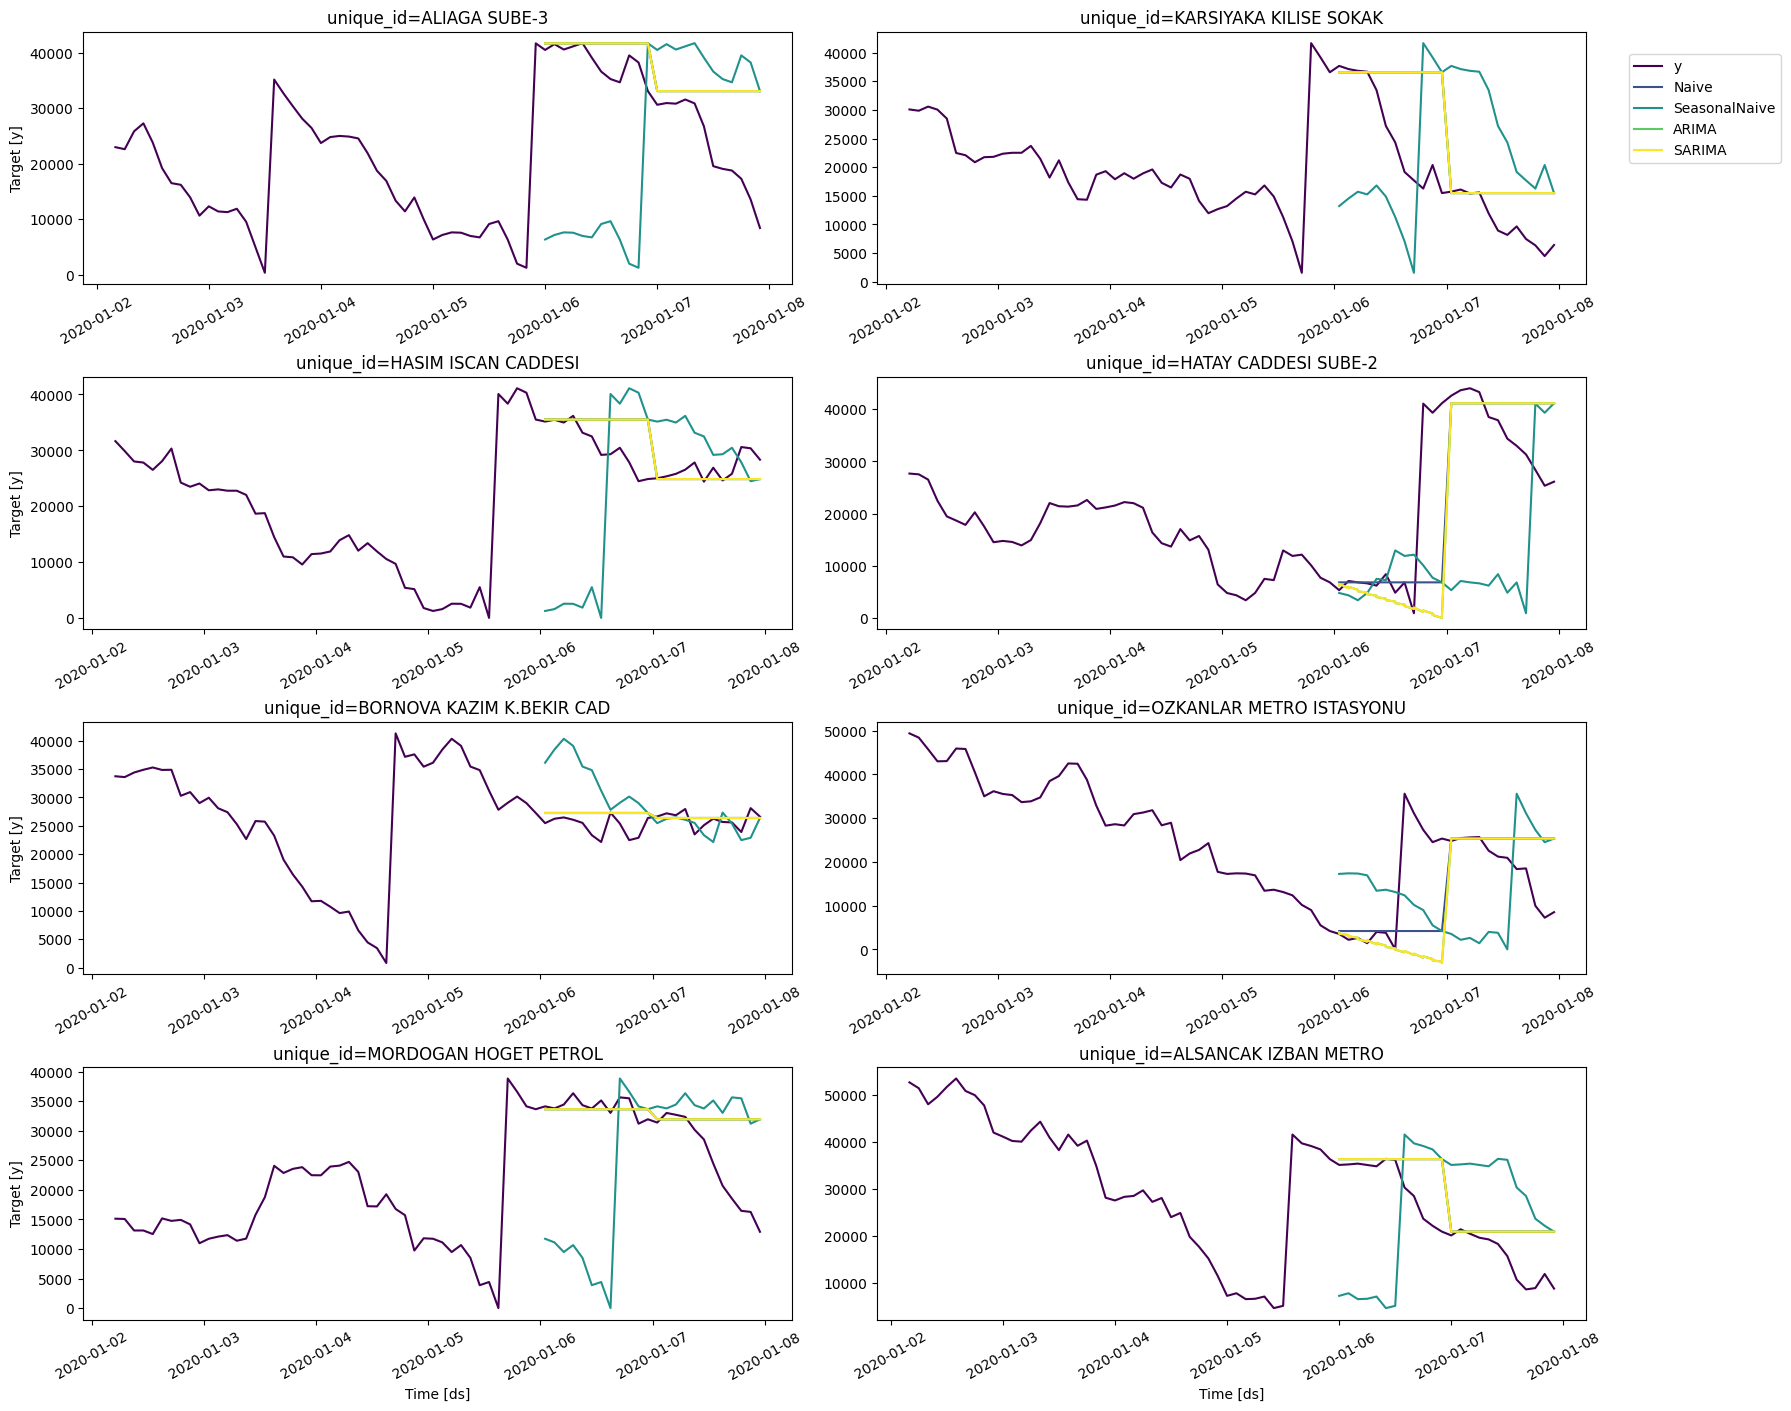

In [34]:
plot_series(
    df=small_df,
    forecasts_df=cv_df.drop(['y','cutoff'],axis=1),
    max_insample_length=140,
    palette="viridis"
)

In [35]:
cv_eval = evaluate(
    df=cv_df.drop(['cutoff'], axis=1),
    metrics=[mae],
)

cv_eval = cv_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()

cv_eval

metric        Naive  SeasonalNaive        ARIMA       SARIMA
0    mae  6929.088379   14130.076172  7261.935059  7259.047852

Exogenous features

In [36]:
df.head()

atmId                unique_id atmCity  \
0  atm350000          ALIAGA BAGLI SB   Izmir   
1  atm350001  ALIAGA ISTIKLAL CADDESI   Izmir   
2  atm350002         ALIAGA PAZARYERI   Izmir   
3  atm350003       ALIAGA SAHIL PARKI   Izmir   
4  atm350004            ALIAGA SUBE-1   Izmir   

                         atmAddress      y  numberIncomeTransition  \
0           Aliaga Petkim Tesisleri  40000                       0   
1        ATATURK ISTIKLAL CD. NO:97  40000                       0   
2        ALIAGA KAPALI PAZAR GIRISI  40000                       0   
3  ALIAGA HIKMET CD.SAHIL PARKI ONU  40000                       0   
4       Istiklal Caddesi No: 64 / A  40000                       0   

   numberOutcomeTransition  totalIncome  totalOutcome  totalNumberTransaction  \
0                        0            0             0                       0   
1                        0            0             0                       0   
2                        0            0             0                       0   
3                        0            0             0                       0   
4                        0            0             0                       0   

         day                   ds  
0  Wednesday  2020-01-01 00:00:00  
1  Wednesday  2020-01-01 00:00:00  
2  Wednesday  2020-01-01 00:00:00  
3  Wednesday  2020-01-01 00:00:00  
4  Wednesday  2020-01-01 00:00:00

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60312 entries, 0 to 60311
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   atmId                    60312 non-null  object
 1   unique_id                60312 non-null  object
 2   atmCity                  60312 non-null  object
 3   atmAddress               60312 non-null  object
 4   y                        60312 non-null  int64 
 5   numberIncomeTransition   60312 non-null  int64 
 6   numberOutcomeTransition  60312 non-null  int64 
 7   totalIncome              60312 non-null  int64 
 8   totalOutcome             60312 non-null  int64 
 9   totalNumberTransaction   60312 non-null  int64 
 10  day                      60312 non-null  object
 11  ds                       60312 non-null  object
dtypes: int64(6), object(6)
memory usage: 5.5+ MB


In [38]:
df['ds'] = pd.to_datetime(df['ds'])

In [39]:
smaller_df = df[['ds', 'y', 'unique_id', 'numberIncomeTransition','totalIncome']].copy()
unique_ids = ['ALIAGA BAGLI SB', 'ALIAGA SUBE-1']
smaller_df = smaller_df[smaller_df['unique_id'].isin(unique_ids)]
test_2 = smaller_df.groupby('unique_id').tail(7)
train_2 = smaller_df.drop(test_2.index).reset_index(drop=True)


In [40]:
last_ts = train_2.groupby('unique_id')['ds'].max()

future_dfs = []
for uid in train_2['unique_id'].unique():
    future_dates = pd.date_range(pd.to_datetime(last_ts[uid]) + pd.Timedelta(hours=1),
                                 periods=horizon, freq = 'h')
    
    last_vals = train_2.loc[train_2['unique_id']==uid, 
                        ['numberIncomeTransition','totalIncome']].iloc[-1]
    
    tmp = pd.DataFrame({
        'unique_id': uid,
        'ds': future_dates,
        'numberIncomeTransition': [last_vals['numberIncomeTransition']] * horizon,
        'totalIncome': [last_vals['totalIncome']] * horizon
    })
    future_dfs.append(tmp)
    
future_exog_df = pd.concat(future_dfs, ignore_index=True)

In [41]:
future_exog_df.shape

(48, 4)

In [42]:
future_exog_df.head()

unique_id                  ds  numberIncomeTransition  totalIncome
0  ALIAGA BAGLI SB 2020-01-07 23:00:00                      87         5315
1  ALIAGA BAGLI SB 2020-01-08 00:00:00                      87         5315
2  ALIAGA BAGLI SB 2020-01-08 01:00:00                      87         5315
3  ALIAGA BAGLI SB 2020-01-08 02:00:00                      87         5315
4  ALIAGA BAGLI SB 2020-01-08 03:00:00                      87         5315

In [43]:
train_2.head()

ds      y        unique_id  numberIncomeTransition  \
0 2020-01-01 00:00:00  40000  ALIAGA BAGLI SB                       0   
1 2020-01-01 00:00:00  40000    ALIAGA SUBE-1                       0   
2 2020-01-01 02:00:00  39850  ALIAGA BAGLI SB                       9   
3 2020-01-01 02:00:00  40510    ALIAGA SUBE-1                       8   
4 2020-01-01 04:00:00  39985  ALIAGA BAGLI SB                       8   

   totalIncome  
0            0  
1            0  
2          485  
3          480  
4          420

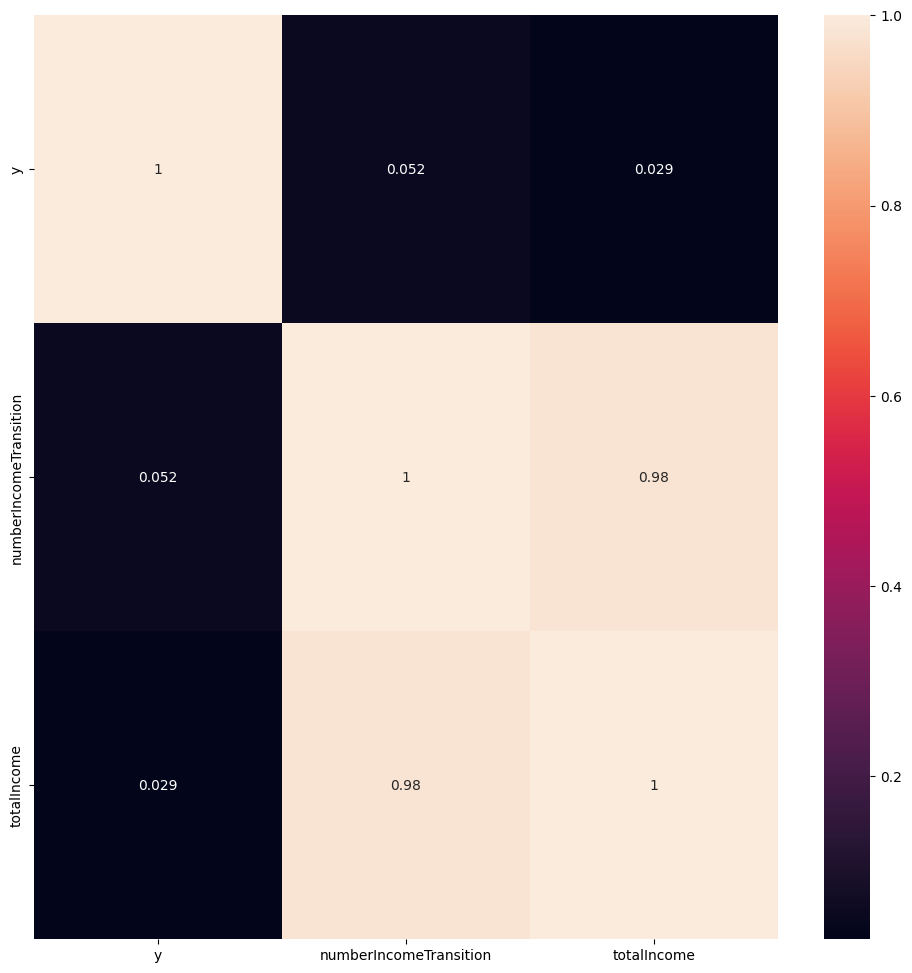

In [44]:
corr = train_2.drop(['ds', 'unique_id'], axis=1).corr()
ax = sns.heatmap(corr, annot=True)

In [45]:
models = [
    AutoARIMA(seasonal=False, alias='ARIMA'),
    AutoARIMA(season_length=24, alias='SARIMA'),
    Naive()
]

sf = StatsForecast(models=models, freq= 'h')

sf.fit(df=train_2.drop(['numberIncomeTransition','totalIncome'], axis = 1))
preds_2_normal = sf.predict(h=horizon)

models = [
    AutoARIMA(seasonal=False, alias='ARIMA_exog'),
    AutoARIMA(season_length=24, alias='SARIMA_exog')
]

sf = StatsForecast(models=models, freq= 'h')

sf.fit(df=train_2)
preds_2_exog = sf.predict(h=horizon, X_df = future_exog_df)

In [46]:
preds_2_normal.info()
preds_2_exog.info()
test_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  48 non-null     object        
 1   ds         48 non-null     datetime64[ns]
 2   ARIMA      48 non-null     float32       
 3   SARIMA     48 non-null     float32       
 4   Naive      48 non-null     float32       
dtypes: datetime64[ns](1), float32(3), object(1)
memory usage: 1.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   unique_id    48 non-null     object        
 1   ds           48 non-null     datetime64[ns]
 2   ARIMA_exog   48 non-null     float32       
 3   SARIMA_exog  48 non-null     float32       
dtypes: datetime64[ns](1), float32(2), object(1)
memory usage: 1.3+ KB
<class 'pandas.core.frame.DataF

In [47]:
test_df = test_2.merge(preds_2_exog, on=['unique_id', 'ds'], how = 'left').merge(preds_2_normal, on = ['unique_id', 'ds'], how = 'left')
test_df

ds      y        unique_id  numberIncomeTransition  \
0  2020-01-07 10:00:00  45935  ALIAGA BAGLI SB                      94   
1  2020-01-07 10:00:00  20005    ALIAGA SUBE-1                      90   
2  2020-01-07 12:00:00  46045  ALIAGA BAGLI SB                      68   
3  2020-01-07 12:00:00  23040    ALIAGA SUBE-1                      83   
4  2020-01-07 14:00:00  48420  ALIAGA BAGLI SB                      83   
5  2020-01-07 14:00:00  19035    ALIAGA SUBE-1                      45   
6  2020-01-07 16:00:00  43430  ALIAGA BAGLI SB                      89   
7  2020-01-07 16:00:00  17630    ALIAGA SUBE-1                      62   
8  2020-01-07 18:00:00  42480  ALIAGA BAGLI SB                      78   
9  2020-01-07 18:00:00  16350    ALIAGA SUBE-1                      65   
10 2020-01-07 20:00:00  34500  ALIAGA BAGLI SB                      53   
11 2020-01-07 20:00:00  13955    ALIAGA SUBE-1                      98   
12 2020-01-07 22:00:00  38050  ALIAGA BAGLI SB                      92   
13 2020-01-07 22:00:00  11170    ALIAGA SUBE-1                      36   

    totalIncome  ARIMA_exog  SARIMA_exog  ARIMA  SARIMA  Naive  
0          6050         NaN          NaN    NaN     NaN    NaN  
1          5880         NaN          NaN    NaN     NaN    NaN  
2          3765         NaN          NaN    NaN     NaN    NaN  
3          5080         NaN          NaN    NaN     NaN    NaN  
4          5085         NaN          NaN    NaN     NaN    NaN  
5          2930         NaN          NaN    NaN     NaN    NaN  
6          5250         NaN          NaN    NaN     NaN    NaN  
7          4075         NaN          NaN    NaN     NaN    NaN  
8          4110         NaN          NaN    NaN     NaN    NaN  
9          4030         NaN          NaN    NaN     NaN    NaN  
10         3395         NaN          NaN    NaN     NaN    NaN  
11         4550         NaN          NaN    NaN     NaN    NaN  
12         6100         NaN          NaN    NaN     NaN    NaN  
13         2410         NaN          NaN    NaN     NaN    NaN

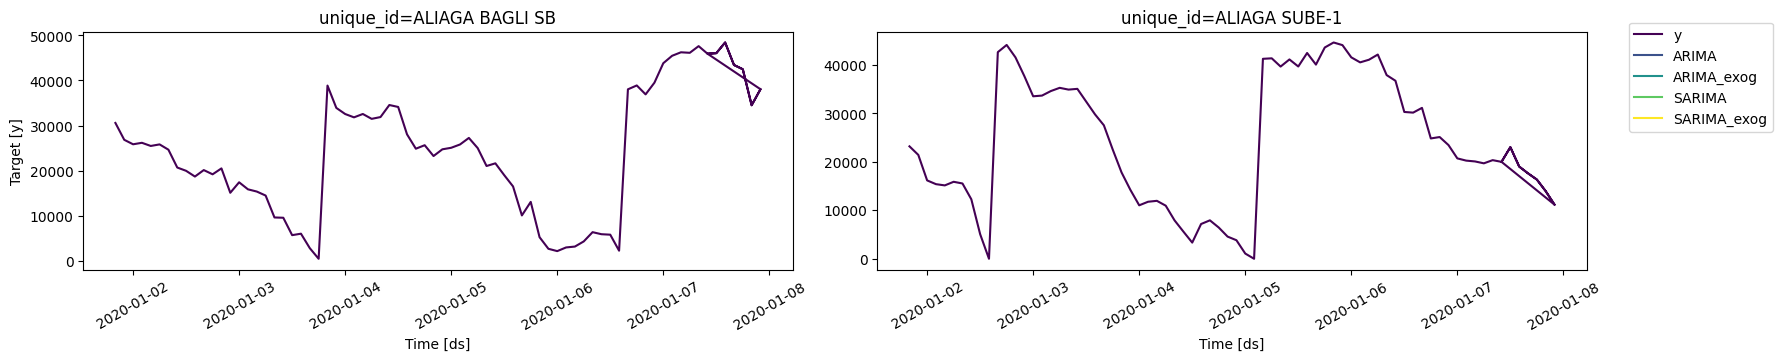

In [48]:
plot_series(
    df=train_2,
    forecasts_df=test_df,
    ids=['ALIAGA BAGLI SB', 'ALIAGA SUBE-1'],
    max_insample_length=140,
    models=['ARIMA','ARIMA_exog','SARIMA','SARIMA_exog'],
    palette='viridis'
)

In [49]:
models = [
    AutoARIMA(seasonal=False, alias='ARIMA_exog'),
    AutoARIMA(season_length=24, alias='SARIMA_exog')
]

sf = StatsForecast(models = models, freq= "h")

cv_exog_df = sf.cross_validation(
    h = horizon,
    df=smaller_df,
    n_windows=2,
    step_size=horizon,
    refit=True
)

cv_exog_df.head()

unique_id                  ds              cutoff       y  \
0  ALIAGA BAGLI SB 2020-01-06 00:00:00 2020-01-05 22:00:00  2145.0   
1  ALIAGA BAGLI SB 2020-01-06 00:00:00 2020-01-05 22:00:00  2145.0   
2  ALIAGA BAGLI SB 2020-01-06 02:00:00 2020-01-05 22:00:00  2960.0   
3  ALIAGA BAGLI SB 2020-01-06 02:00:00 2020-01-05 22:00:00  2960.0   
4  ALIAGA BAGLI SB 2020-01-06 04:00:00 2020-01-05 22:00:00  3155.0   

    ARIMA_exog  SARIMA_exog  
0  2333.553223  2333.553223  
1  2333.553223  2333.553223  
2  2333.810303  2333.810303  
3  2333.810303  2333.810303  
4  2402.830811  2402.830811

In [50]:
cv_exog_eval = evaluate(
    df=cv_exog_df.drop(['cutoff'], axis = 1),
    metrics=[mae],
)

cv_exog_eval = cv_exog_eval.drop(['unique_id'], axis = 1).groupby('metric').mean().reset_index()

cv_exog_eval

metric   ARIMA_exog  SARIMA_exog
0    mae  7285.238281  7285.238281

Creating Features from Timestamps

In [51]:
features = [
    partial(fourier, season_length=24, k=1),
    partial(time_features, features=['day', 'hour', 'minute'])
]

small_exog_df, futr_exog_df = pipeline(
    df=smaller_df,
    features=features,
    freq='h',
    h=horizon
)

In [52]:
small_exog_df.head()

ds      y        unique_id  numberIncomeTransition  \
0   2020-01-01 00:00:00  40000  ALIAGA BAGLI SB                       0   
4   2020-01-01 00:00:00  40000    ALIAGA SUBE-1                       0   
359 2020-01-01 02:00:00  39850  ALIAGA BAGLI SB                       9   
363 2020-01-01 02:00:00  40510    ALIAGA SUBE-1                       8   
718 2020-01-01 04:00:00  39985  ALIAGA BAGLI SB                       8   

     totalIncome   sin1_24   cos1_24  day  hour  minute  
0              0  0.258819  0.965926    1     0       0  
4              0  0.258819  0.965926    1     0       0  
359          485  0.707107  0.707107    1     2       0  
363          480  0.707107  0.707107    1     2       0  
718          420  0.965926  0.258819    1     4       0

In [53]:
futr_exog_df.head()

unique_id                  ds   sin1_24   cos1_24  day  hour  minute
0  ALIAGA BAGLI SB 2020-01-07 23:00:00  0.258821  0.965925    7    23       0
1  ALIAGA BAGLI SB 2020-01-08 00:00:00  0.500001  0.866025    8     0       0
2  ALIAGA BAGLI SB 2020-01-08 01:00:00  0.707108  0.707106    8     1       0
3  ALIAGA BAGLI SB 2020-01-08 02:00:00  0.866026  0.500000    8     2       0
4  ALIAGA BAGLI SB 2020-01-08 03:00:00  0.965926  0.258819    8     3       0

In [54]:
models = [
    AutoARIMA(season_length=24, alias='SARIMA_time_exog'),
    AutoARIMA(seasonal=False, alias='ARIMA_time_exog')
]

sf = StatsForecast(models=models, freq='h')

cv_time_exog_df = sf.cross_validation(
    h=horizon,
    df=smaller_df,
    n_windows=2,
    step_size=horizon,
    level=[80],
    refit=True
)

cv_time_exog_eval = evaluate(
    cv_time_exog_df.drop(['cutoff'], axis = 1),
    metrics=[mae],
)

cv_time_exog_eval = cv_time_exog_eval.drop(['unique_id'], axis = 1).groupby('metric').mean().reset_index()
cv_time_exog_eval

metric  SARIMA_time_exog  ARIMA_time_exog
0    mae       7285.238281      7285.238281

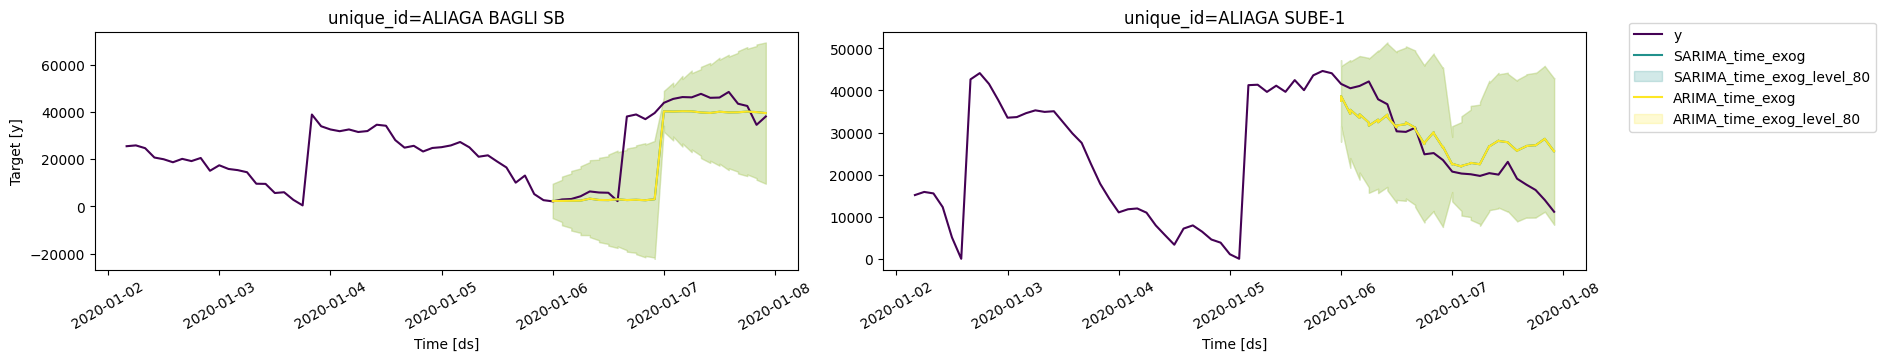

In [55]:
plot_series(
    df=smaller_df,
    forecasts_df=cv_time_exog_df.drop(['y', 'cutoff'], axis=1),
    ids = ['ALIAGA BAGLI SB', 'ALIAGA SUBE-1'],
    max_insample_length=140,
    level=[80],
    palette='viridis'
)

In [56]:
models = [
    AutoARIMA(season_length=24, alias = 'SARIMA_exog'),
    SeasonalNaive(season_length=24)
]

sf = StatsForecast(models = models, freq = 'h')

final_cv = sf.cross_validation(
    h=horizon,
    df = smaller_df,
    n_windows = 2,
    step_size = horizon,
    refit=True,
    level=[80] 
)

In [57]:
final_cv.head()

unique_id                  ds              cutoff       y  \
0  ALIAGA BAGLI SB 2020-01-06 00:00:00 2020-01-05 22:00:00  2145.0   
1  ALIAGA BAGLI SB 2020-01-06 00:00:00 2020-01-05 22:00:00  2145.0   
2  ALIAGA BAGLI SB 2020-01-06 02:00:00 2020-01-05 22:00:00  2960.0   
3  ALIAGA BAGLI SB 2020-01-06 02:00:00 2020-01-05 22:00:00  2960.0   
4  ALIAGA BAGLI SB 2020-01-06 04:00:00 2020-01-05 22:00:00  3155.0   

   SARIMA_exog  SARIMA_exog-lo-80  SARIMA_exog-hi-80  SeasonalNaive  \
0  2333.553223       -2805.749023        7472.855469        25065.0   
1  2333.553223       -4934.517578        9601.624023        25065.0   
2  2333.810303       -6567.722168       11235.342773        25800.0   
3  2333.810303       -7944.793945       12612.415039        25800.0   
4  2402.830811       -9088.998047       13894.660156        27250.0   

   SeasonalNaive-lo-80  SeasonalNaive-hi-80  
0          4546.688965           45583.3125  
1          4546.688965           45583.3125  
2          5281.688965           46318.3125  
3          5281.688965           46318.3125  
4          6731.688965           47768.3125

In [58]:
temp_test = smaller_df.groupby('unique_id').tail(7*8)
temp_train = smaller_df.drop(temp_test.index).reset_index(drop=True)

In [59]:
models = ['SARIMA_exog', 'SeasonalNaive']
metrics = [
    mae,
    mse,
    rmse,
    mape,
    smape,
    partial(mase, seasonality = 24),
    scaled_crps
]

final_eval = evaluate(
    final_cv.drop(['ds', 'cutoff'], axis = 1),
    metrics = metrics,
    models = models,
    train_df=temp_train,
    level=[80]
)

final_eval = final_eval.drop(['unique_id'], axis = 1).groupby('metric').mean().reset_index()

final_eval

metric   SARIMA_exog  SeasonalNaive
0          mae  7.285239e+03   2.043385e+04
1         mape  3.036654e-01   1.475681e+00
2         mase  3.892937e-01   1.094575e+00
3          mse  1.364073e+08   6.007313e+08
4         rmse  1.090487e+04   2.383198e+04
5  scaled_crps  1.575754e-01   3.493306e-01
6        smape  1.794867e-01   4.562687e-01

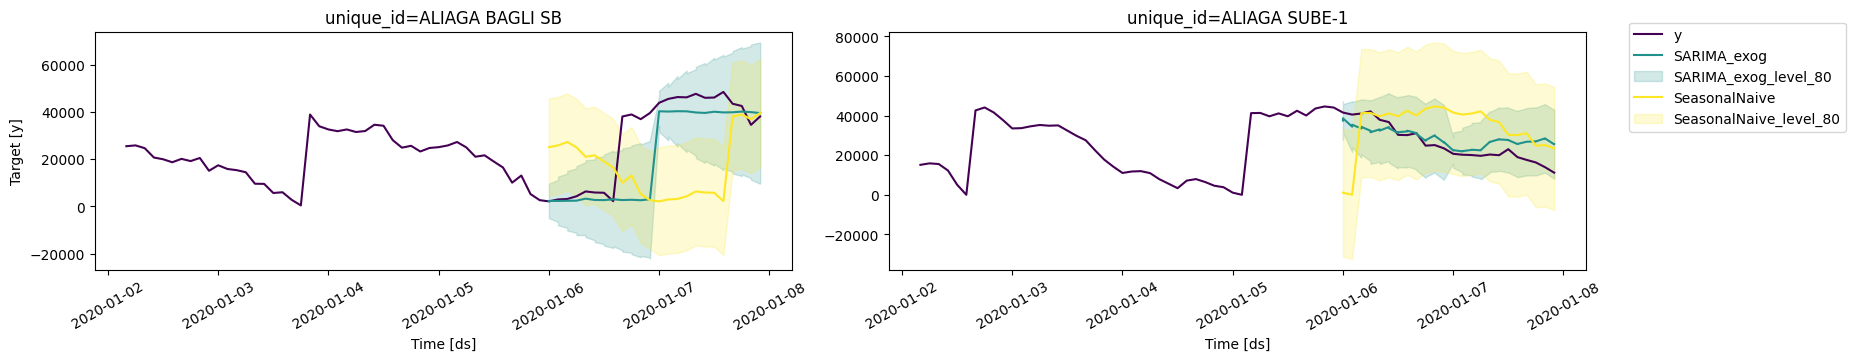

In [60]:
plot_series(
    df=smaller_df,
    forecasts_df=final_cv.drop(['y', 'cutoff'], axis=1),
    ids = ['ALIAGA BAGLI SB', 'ALIAGA SUBE-1'],
    max_insample_length=140,
    level=[80],
    palette='viridis'
)

Prophet

12:14:03 - cmdstanpy - INFO - Chain [1] start processing
12:14:15 - cmdstanpy - INFO - Chain [1] done processing


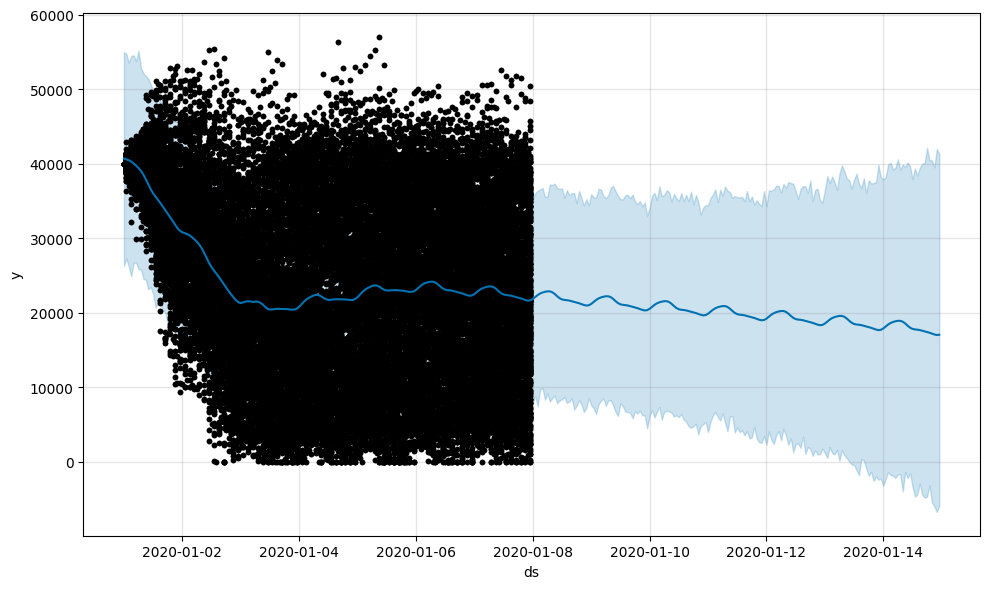

In [61]:
m = Prophet(changepoint_prior_scale=0.01).fit(small_df)
future = m.make_future_dataframe(periods=24*7, freq = 'h')
fcst = m.predict(future)
fig = m.plot(fcst)

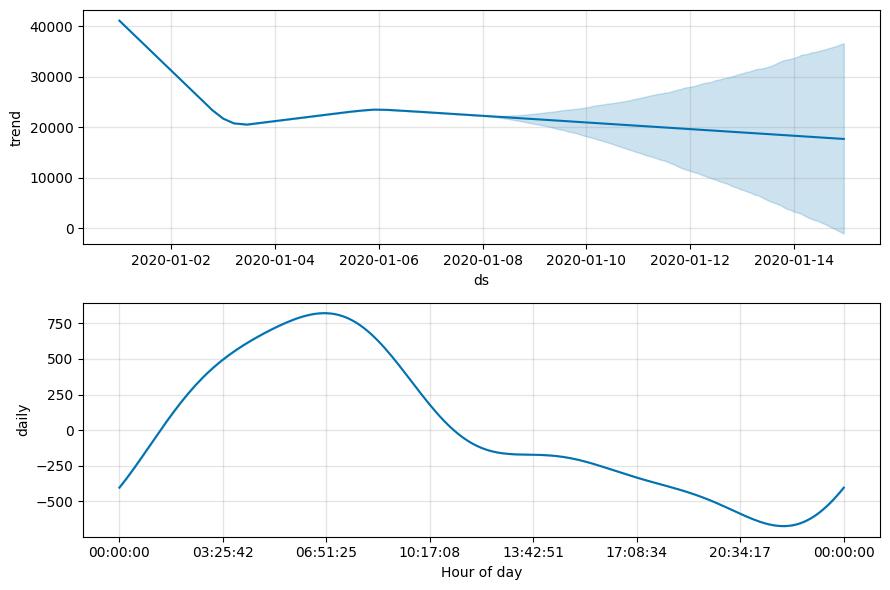

In [62]:
fig = m.plot_components(fcst)

In [63]:
small_df.tail()

ds      y            unique_id
60307 2020-01-07 23:00:00  16665       TORBALI SUBE-2
60308 2020-01-07 23:00:00   7925          URLA ISKELE
60309 2020-01-07 23:00:00  25920  URLA MEYDAN AVM ONU
60310 2020-01-07 23:00:00  30295          URLA SUBE-1
60311 2020-01-07 23:00:00  11040          URLA SUBE-2

In [64]:
cutoffs = pd.to_datetime(['2020-01-04 23:00:00'])
m_cv = cross_validation(m, cutoffs=cutoffs, horizon = '3 days')
m_cv.head()

  0%|          | 0/1 [00:00<?, ?it/s]

12:14:18 - cmdstanpy - INFO - Chain [1] start processing
12:14:25 - cmdstanpy - INFO - Chain [1] done processing


ds          yhat    yhat_lower    yhat_upper      y  \
0 2020-01-05  22183.053281   9298.705329  35493.381951  25065   
1 2020-01-05  22183.053281  10204.791062  35653.673714  40325   
2 2020-01-05  22183.053281   8755.123852  35205.962276   4230   
3 2020-01-05  22183.053281   9305.341495  35789.862375   3950   
4 2020-01-05  22183.053281   9365.101897  34487.126160   1080   

               cutoff  
0 2020-01-04 23:00:00  
1 2020-01-04 23:00:00  
2 2020-01-04 23:00:00  
3 2020-01-04 23:00:00  
4 2020-01-04 23:00:00

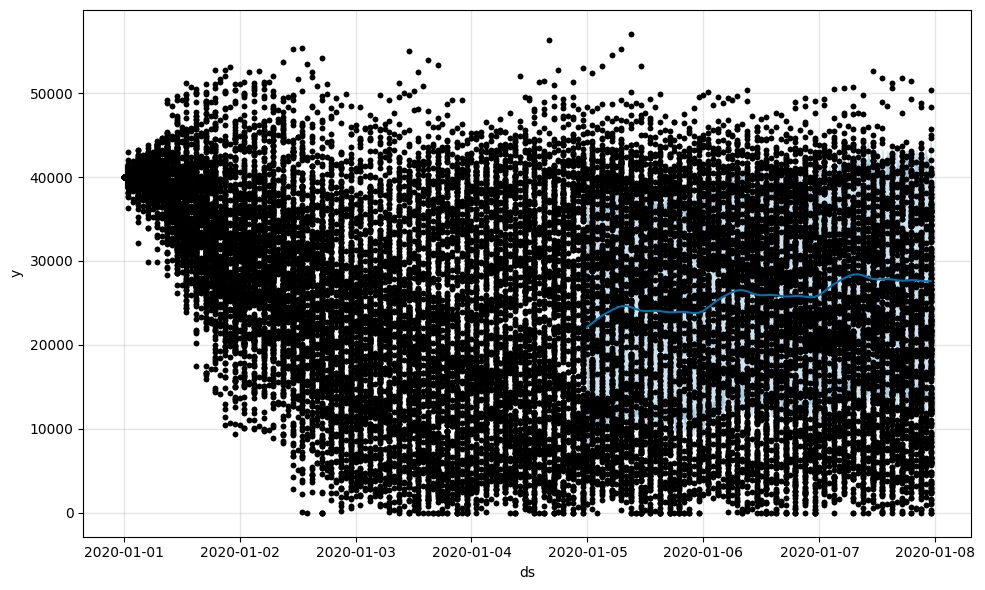

In [65]:
fig = m.plot(m_cv)

In [66]:
m_p = performance_metrics(m_cv)
m_p.head()

horizon           mse          rmse           mae     mdape  \
0 0 days 08:00:00  1.613885e+08  12703.877884  11038.367299  0.393902   
1 0 days 09:00:00  1.630015e+08  12767.205168  11105.368786  0.393168   
2 0 days 10:00:00  1.651028e+08  12849.231539  11160.784508  0.390542   
3 0 days 11:00:00  1.665031e+08  12903.609124  11218.184402  0.389308   
4 0 days 12:00:00  1.683263e+08  12974.061618  11248.288793  0.387118   

      smape  coverage  
0  0.526294  0.577691  
1  0.531073  0.573024  
2  0.536205  0.569184  
3  0.539334  0.566824  
4  0.548288  0.567222

In [67]:
@register_performance_metric
def mase(df, w):
    e = (df['y'] - df['yhat'])
    d = np.abs(np.diff(df['y'])).sum()/(df['y'].shape[0]-1)
    se = np.abs(e/d)
    if w < 0:
        return pd.DataFrame({'horizon': df['horizon'], 'mase' : se})
    return rolling_mean_by_h(
        x=se.values, h=df['horizon'].values, w=w, name='mase'
    )
    
df_mase = performance_metrics(m_cv, metrics = ['mase'])
df_mase.head()

horizon      mase
0 0 days 08:00:00  0.776565
1 0 days 09:00:00  0.781279
2 0 days 10:00:00  0.785177
3 0 days 11:00:00  0.789215
4 0 days 12:00:00  0.791333

c:\Users\HP\OneDrive\Documents\EXP2\exp2\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\HP\OneDrive\Documents\EXP2\exp2\Lib\site-packages\prophet\plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


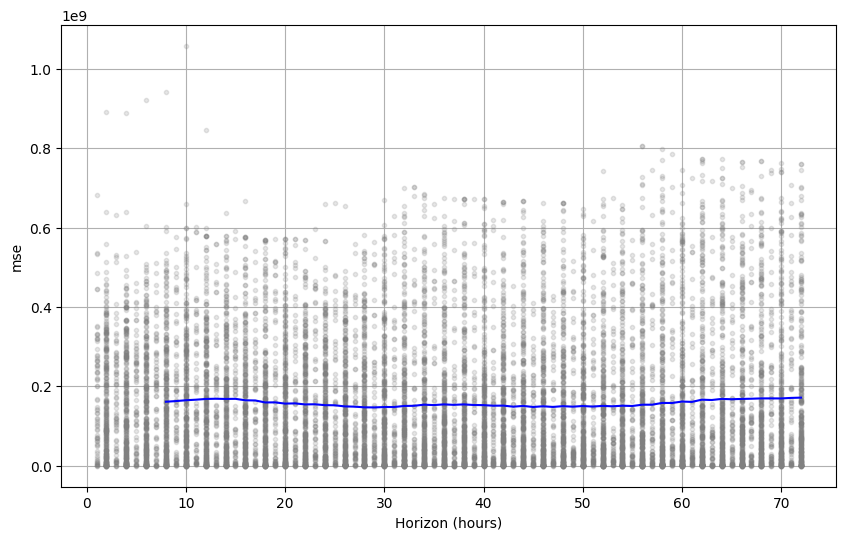

In [68]:
fig = plot_cross_validation_metric(m_cv, metric='mse')

In [69]:
plot_plotly(m, fcst)